# Homodyne tomography

In [1]:
# Importing libraries
import numpy as np
import scipy as sp
import pandas as pd
import os
from pathlib import Path
import sys
import json
from scipy.fft import rfft, irfft, rfftfreq
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# Importing functions
from utils import *

# Global plot style settings
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",            # Use Computer Modern for math
    "font.size": 14,                     # Base font size
    "axes.labelsize": 16,                # Axis label font size
    "axes.titlesize": 16,                # Title font size
    "legend.fontsize": 13,               # Legend font size
    "xtick.labelsize": 13,               # X tick label size
    "ytick.labelsize": 13,               # Y tick label size
    "axes.linewidth": 1.2,               # Thicker axis lines
    "xtick.direction": "in",             # x-yick direction
    "ytick.direction": "in",             # y-tick direction
    "text.usetex": False,                # Enable LaTeX if needed
    "figure.dpi": 100,                   # Good resolution for screens
    "savefig.dpi": 300                   # High resolution for saving
})

# Define function for nice plotting
def PlotSettings(ax, gridlines=False, minimalist=False):
    # Minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    # Minimalist style
    if minimalist:
        # Hide top and right spines (borders)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Ticks only on bottom and left
        ax.tick_params(which='both', top=False, right=False)
    else:
        # Tick parameters
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.tick_params(which='major', length=7, width=1.2)
        ax.tick_params(which='minor', length=4, width=1)
    # Optional grid
    if gridlines:
        ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
        ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.4)

### What is Homodyne tomography?

Homodyne tomography is a method for reconstructing quantum states of light by measuring field quadratures $Q_\theta$ at different local oscillator (LO) phases $\theta$ using a Homodyne detection scheme. From these measurements, one can recover the Wigner function $W(Q,P)$ and density matrix $\rho$, which makes it a key tool for verifying the preparation of nonclassical states in quantum optics.

<img src="../images/HomodyneTomography.png" alt="Homodyne Tomography" height="250"/>
<img src="../images/HomodyneDetector.png" alt="Homodyne Detector" height="250"/>

In the paper *Optical Continuous-Variable Qubit* (see references), superpositions of squeezed vacuum and squeezed single-photon states were engineered using photon subtraction. The setup employed an optical parametric oscillator (OPO) to generate squeezed vacuum, a small fraction of which was tapped off, displaced, and detected by an avalanche photodiode (APD). Conditional detection prepared the desired superpositions, which were then analyzed using balanced homodyne detection across multiple LO phases.

<img src="../images/ExperimentalSetup.png" alt="Homodyne Tomography" height="500"/>

In this notebook, we work with the experimental data obtained using this setup. Our goal is to benchmark and compare two different reconstruction methods - Maximum Likelihood Estimation (MLE) and Bayesian Mean Estimation (BME) - to reproduce the Wigner functions reported in the paper.

### Loading and processing data

We start by downloading and un-zipping the data from the dropbox link bellow (you should too):

https://www.dropbox.com/scl/fi/0cb9i9vx9w0b1lpro8wpq/data-tora.zip?rlkey=nkouczz7r9ylnmkd3n639z7kt&dl=0

After downloading and un-zipping, put the **data-tora** folder into the **data** folder in the repo

The data was acquired by a LeCroy HDO6034 oscilloscope. Since it is in a proprietary binary format, we use the script **lecroy.py** to import it. Based on the folder and file structure of the **data-tora** folder, we created a script for processing the data collecting all the traces corresponding to different phases into a single .npy file for each state.

In [80]:
parent = str(Path.cwd().parent)

In [ ]:
parent 

'c:\\Users\\tbrav\\OneDrive - Danmarks Tekniske Universitet\\Engineering Physics - MSc\\Sem 2\\10387 Scientific Computing in Quantum Information Science\\Homodyne-Tomography'

In [78]:
%run preprocess_data.py {parent}

FileNotFoundError: [WinError 3] Den angivne sti blev ikke fundet: 'c:\\Users\\tbrav\\OneDrive\\data\\data-tora'

In [2]:
path = Path(os.path.dirname(os.getcwd()))
date = "091027"
state = "cat2"

data_path = path / "data" / "processed_data" / date
data = np.load(data_path / (state + '.npy'))

dt = json.load(open(data_path / 'dts.json'))[state]
N = data.shape[2]
t = np.linspace(0, dt*N, N, endpoint=False)

In [3]:
data.shape

(13, 30000, 127)

The structure of the .npy file is (n_angles, n_traces, n_measurements). Bellow we plot a single trace.

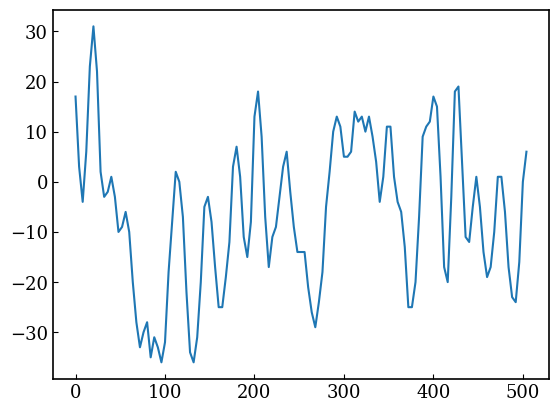

In [4]:
plt.plot(t*1e9, data[0, 0, :])

### Calculating quadrature values

$$
Q_\theta=\int_{-\infty}^\infty f_s(t)Q_\theta(t)dt,\quad f_s(t)=\sqrt{\gamma}e^{-\gamma|t|}
$$

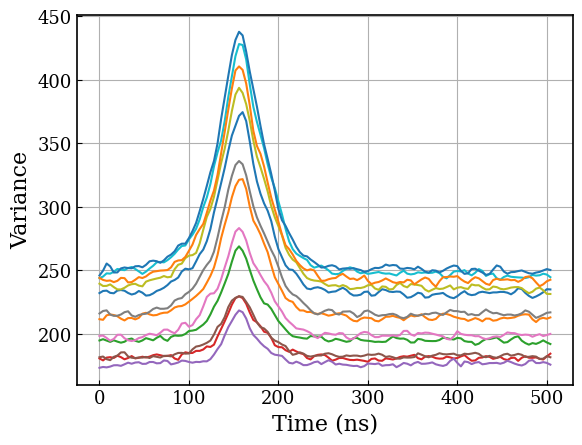

In [5]:
for i in range(12):
    state = data[i,:,:]
    state_var = state.var(axis=0)
    plt.plot(t*1e9, state_var, label=f'{15*i} deg')
#plt.plot(t*1e9, temporal_mode, label='Temporal Mode')
#plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

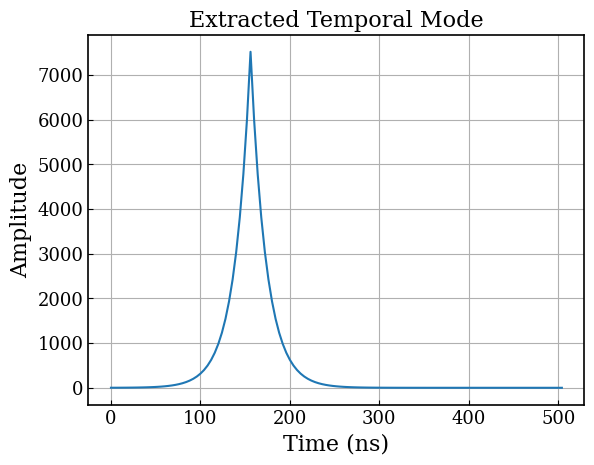

In [6]:
# Extract vacuum data
vacuum = data[-1,:,:]

# Define temporal mode from peak in variance
temporal_mode = fs(t, t[39])  # shape (T,)

#temporal_mode /= np.linalg.norm(temporal_mode)

plt.plot(t*1e9, temporal_mode)
plt.title("Extracted Temporal Mode")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

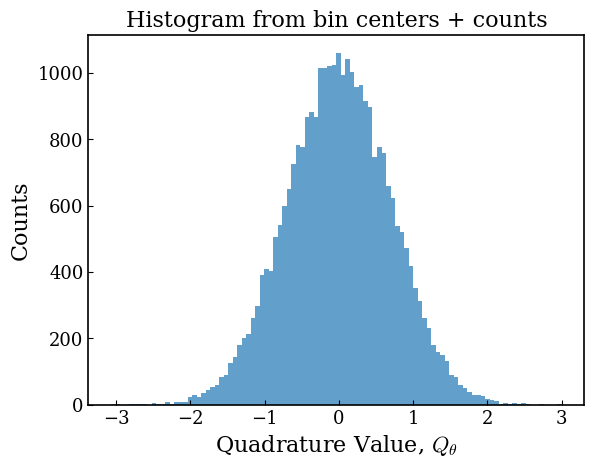

In [25]:
vacuum_quadratures = vacuum @ temporal_mode * dt
vacuum_mean = np.mean(vacuum_quadratures)
vacuum_std = np.std(vacuum_quadratures)
vacuum_quadratures -= vacuum_mean
vacuum_quadratures /= np.sqrt(2)*vacuum_std
bin_centers, counts = bin_X(vacuum_quadratures, num_bins=100)

# Ensure proper dtype + flatten
bin_centers = np.array(bin_centers, dtype=float).ravel()
counts = np.array(counts, dtype=int).ravel()

# Expand counts into repeated data
data = np.repeat(bin_centers, counts)

plt.hist(data, bins=len(bin_centers), alpha=0.7)
plt.xlabel("Quadrature Value, $Q_\\theta$")
plt.ylabel("Counts")
plt.title("Histogram from bin centers + counts")
plt.show()

### Reconstruction algoritms

We now have the main "ingredients" for the resconstruction

#### Itterative Maxium Likelihood Estimation (iMLE)

The likelihood of observing 
$$
\ln{\mathcal{L}}=\sum_i f_i\ln\mathrm{pr}_{\theta_i}(x_i)
$$

Itteration operator
$$
\hat{R}(\hat{\rho})=\sum_i\frac{c_i}{\mathrm{pr}_{\theta_i}(x_i)} |\psi_i\rangle\langle\psi_i|
$$
where
$$
|\psi_i\rangle=|\theta,x\rangle
$$

$$
\ln{\mathcal{L}}=\sum_i f_i\ln\mathrm{pr}_{\theta_i}(x_i)
$$

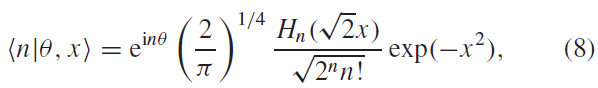

#### Bayesian Mean Estimation (BME)

BME is a Bayesian approach to estimating parameters of a probability distribution. Here’s the idea step by step, as explained in [X] [this paper](https://iopscience.iop.org/article/10.1088/1367-2630/12/4/043034/pdf):

1. Use the data to generate a likelihood function, $\mathcal{L}(\rho) = p(M|\rho)$. $\mathcal{L}$ is not a probability
distribution; it quantifies the relative plausibility of different state assignments.

2. Choose a prior distribution over states, $\pi_{0}(\rho)d\rho$. It represents the estimator’s ignorance,
and should generally be chosen to be as ‘uniform’, or uninformative, as possible.

3. Multiply the prior by the likelihood and normalize to obtain a posterior distribution

$$
\pi_{f}(\rho)d\rho \propto \mathcal{L}(\rho)\pi_{0}(\rho)d\rho
$$ 

which represents the estimator’s knowledge. The proportionality constant is set by normalization.

4. Report the mean of this posterior,

$$
\hat\rho_{BME} = \int \rho \pi_{f}(\rho)d\rho
$$

This is the best concise description of the estimator’s knowledge.

The main goal is to find a Markoc chain of density matrices that, when averaged, gives the posterior mean $\hat\rho_{BME}$. There are multiple algorithms to build this chain, but in this project we have implemented the Metropolis-hastings method. This works as follows:
1. Start with an initial guess for the density matrix $\rho^{(0)}$. In our case, we have assumed $\rho_0 = \frac{I}{2}$, the maximally mixed state.
2. Propose a new density matrix $\rho'$ by perturbing the current state $\rho$ with a small random step. This is done by Cholesky parametrization, where we decompose the density matrix into a lower triangular matrix T such that 
$$
\rho = \frac{T^\dagger T}{\mathrm{Tr}(T^\dagger T)}
$$
Then, we perturb T by adding a small (multiplied by a factor $\epsilon$) random (sampled from a $\mathcal{N}(0,1)$) matrix $\Delta T$, done by multiplying a random lower triangular complex matrix (generated by $\mathcal{N}(0,1)$) by a small factor $\epsilon$, and the resulting new density matrix is given by:
$$
\rho' = \frac{(T + \epsilon \Delta T)^\dagger (T + \epsilon \Delta T)}{\mathrm{Tr}((T + \epsilon \Delta T)^\dagger (T + \epsilon \Delta T))}
$$

3. Calculate the acceptance probability $\alpha = \min\left(1, \frac{P(\rho')}{P(\rho)}\right)$. In our case, we use log $\alpha$ instead, which is given by:
$$
\log \alpha = (\log \mathcal{L}(\rho') + \log \pi_0(\rho')) - (\log \mathcal{L}(\rho) - \log \pi_0(\rho))
$$

4.  Generate a random number $r$ from a uniform distribution $U(0,1)$, calculate its logarithm, and compare it to $\log \alpha$. If $\log r < \log \alpha$, accept the new state $\rho'$, otherwise keep the current state $\rho$.

5. Repeat steps 2-4 for as many iterations as needed to build a Markov chain of density matrices.

As part of the last steps, we get rid of the first 20% of the chain (burn-in) since they strongly depend on the initial guess $\rho^{(0)}$, and average the remaining states to get the final estimate $\hat\rho_{BME}$. The log-likelihood is also averaged over the same chain.

### Benchmarks and comparisons

In [6]:
import tkinter as tk
from tkinter import filedialog, messagebox
import os

# Files we expect in the folder
REQUIRED_FILES = ["data.txt", "config.json"]

folder_path = None

def select_folder():
    global folder_path
    folder = filedialog.askdirectory(title="Select a folder", parent=root)
    if folder:
        folder_path = folder
        label.config(text=f"Selected: {folder}")
        print("Selected folder:", folder)
    else:
        folder_path = None
        label.config(text="No folder selected")

def process_data():
    if not folder_path:
        messagebox.showerror("Error", "No folder selected!")
        return

    # Check required files
    missing = [f for f in REQUIRED_FILES if not os.path.isfile(os.path.join(folder_path, f))]
    if missing:
        messagebox.showerror("Error", f"Missing required files: {', '.join(missing)}")
        return

    # If everything is fine
    messagebox.showinfo("Success", "Folder contains all required files. Processing...")
    print("Processing data in:", folder_path)
    # ---- Your data processing code goes here ----

root = tk.Tk()
root.title("Folder Selector")

# Make sure the window starts in front
root.lift()
root.attributes('-topmost', True)
root.after_idle(root.attributes, '-topmost', False)

# Buttons
button_select = tk.Button(root, text="Choose Folder", command=select_folder, padx=10, pady=5)
button_select.pack(pady=10)

button_process = tk.Button(root, text="Process Data", command=process_data, padx=10, pady=5)
button_process.pack(pady=10)

# Label
label = tk.Label(root, text="No folder selected", wraplength=400)
label.pack(pady=10)

root.mainloop()


Selected folder: C:/Users/tbrav/OneDrive - Danmarks Tekniske Universitet/Engineering Physics - MSc/Sem 2/10387 Scientific Computing in Quantum Information Science/Homodyne-Tomograpy/data/data-tora


KeyboardInterrupt: 